# Election simulator, polls only

Methodology:

For a single battleground state, say Florida

Take a kernel density estimate of the Biden and Trump polling sample data

This should be a single KDE fitted to net Biden margin (>0 = he wins, <0= he loses)

Optimise the bandwidth according to some objective

Run 10k pseudoexperiments by sampling from this KDE, compute the distribution of outcomes

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import ds_toolbox.modelling.time_series_utils as ts
import ds_toolbox.modelling.misc_utils as ds
from ds_toolbox.visualisation import corrplot, bokeh_chart, bokeh_candlestick, plot_colors

from bokeh.plotting import show, output_notebook
output_notebook()

# pd.set_option("display.max_columns", None)

Loading BokehJS ...

In [2]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [3]:
raw = pd.read_csv("data/presidential_polls_2020_538.csv")

raw.created_at = pd.to_datetime(raw.created_at)
raw = raw[raw.answer.isin(["Biden", "Trump"])]

# keep only state-level polls
raw = raw[raw.state.notna()]

# keep only answers from likely voters (population and population_full are always equal)
raw = raw[raw.population == "lv"]

In [4]:
states = raw.state.unique()

In [5]:
wide = raw.pivot_table(index="created_at", columns=["state", "answer"], values="pct")

In [6]:
battlegrounds = ['Arizona',
 'Colorado',
 'Florida',
 'Georgia',
 'Iowa',
 'Maine',
 'Michigan',
 'Minnesota',
 'Nevada',
 'New Hampshire',
 'New Mexico',
 'North Carolina',
 'Ohio',
 'Pennsylvania',
 'Texas',
 'Virginia',
 'Wisconsin']

party_colors = ["red", "dodgerblue"]

## test KDE on single state (skip)

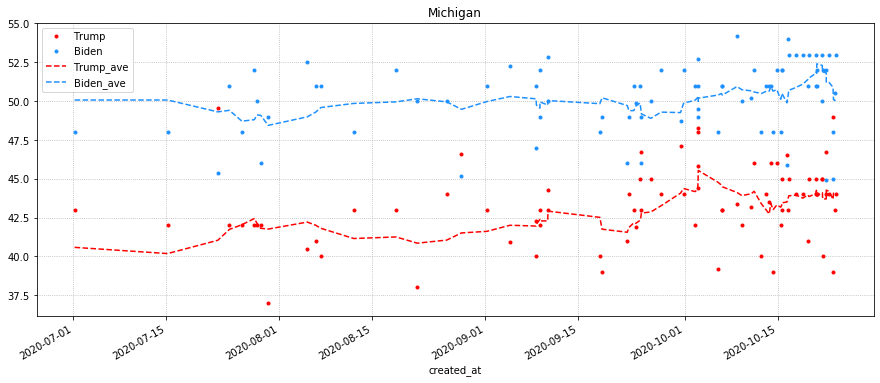

In [7]:
for state in ["Michigan"]:
    plot_df = wide[state].dropna()[["Trump", "Biden"]]
    plot_df_roll = plot_df.rolling(window=10, min_periods=3).mean()
    plot_df_roll.columns = ["Trump_ave", "Biden_ave"]
    plot_df = plot_df.merge(plot_df_roll, left_index=True, right_index=True, how="left")
    ts.plot(plot_df, style=[".", ".", "--", "--"], start_date="2020-07", color=2*party_colors)
    plt.title(state);


In [8]:
df = plot_df[plot_df.index >= "2020-07"]

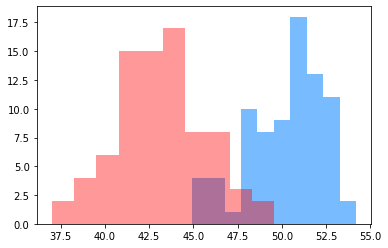

In [9]:
plt.hist(df.Biden, bins=10, color="dodgerblue", alpha=0.6);
plt.hist(df.Trump, bins=10, color="red", alpha=0.4);


In [10]:
# plt.hist(df.Biden - df.Trump, bins=40, color="mediumpurple", alpha=0.8);

In [11]:
# for bandwidth in [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 1.5, 3, 5]:
#     net_biden = (df.Biden - df.Trump).to_frame()
#     kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(net_biden)
#     samples = kde.sample(10000)
#     plt.hist(samples, bins=100, label=str(bandwidth));
#     frac_biden = (np.squeeze(samples) > 0).sum() / 10000
#     print(frac_biden)
#     plt.legend()
#     plt.show()

In [12]:
# X = np.linspace(40, 60, 51).reshape(-1, 1)
# log_dens = kde.score_samples(X)
# plt.plot(X, np.exp(log_dens));

### optimise bandwidth

In [14]:
# # use grid search cross-validation to optimize the bandwidth
# params = {'bandwidth': np.logspace(-1, 1, 20)}
# grid = GridSearchCV(KernelDensity(kernel="gaussian"), params)
# grid.fit(net_biden)

# print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))

# # seems way too low

## All batteground states  

Use bandwidth of 5

In [15]:
safe_rep = ['Alabama',
 'Alaska',
 'Arkansas',
 'Idaho',
 'Indiana',
 'Kansas',
 'Kentucky',
 'Louisiana',
 'Mississippi',
 'Missouri',
 'Montana',
 'Nebraska',
 'North Dakota',
 'Oklahoma',
 'South Carolina',
 'South Dakota',
 'Tennessee',
 'Utah',
 'West Virginia',
 'Wyoming']

safe_dem = ['California',
 'Connecticut',
 'Delaware',
 'District of Columbia',
 'Hawaii',
 'Illinois',
 'Maryland',
 'Massachusetts',
 'New Jersey',
 'New York',
 'Oregon',
 'Rhode Island',
 'Vermont',
 'Washington']

In [16]:
# downloaded from https://state.1keydata.com/state-electoral-votes.php
votes_per_state = pd.read_csv("data/electoral_votes_per_state.csv", 
                              header=None, index_col=0, names=["votes"]).squeeze()


In [180]:
n_mc = 100000

df_all = pd.DataFrame(index=range(n_mc), columns=states)

df_all[safe_dem] = "D"
df_all[safe_rep] = "R"

for state in battlegrounds:
    results = simulate_state(state, n_mc=n_mc, bandwidth=5, shy_trump=0)
    df_all[state] = results

In [181]:
# this approach wasn't any faster than the explicit for loop

# dfT = df_all.T
# dfT.apply(count_states, axis=0)

In [182]:
dem_distr = np.empty(n_mc)
rep_distr = np.empty(n_mc)

for row in df_all.itertuples(name=None):
    i = row[0]
    vals = np.array(row[1:])
    idx_d = np.where(vals == "D")[0]
    idx_r = np.where(vals == "R")[0]
    voted_dem = df_all.columns[idx_d]
    voted_rep = df_all.columns[idx_r]
    dem_total = votes_per_state[voted_dem].sum()
    rep_total = votes_per_state[voted_rep].sum()
  
    dem_distr[i] = dem_total
    rep_distr[i] = rep_total


### conditional probability

What is the probability of a Biden win under various battlegrounds voting Rep?

In [183]:
# df = df_all[df_all.Pennsylvania == "R"].reset_index()
condition = (df_all.Pennsylvania == "R") & (df_all.Florida == "R") & (df_all.Wisconsin == "R")
df = df_all[condition].reset_index()

dem_distr = np.empty(len(df))
rep_distr = np.empty(len(df))

for row in df.itertuples(name=None):
    i = row[0]
    vals = np.array(row[1:])
    idx_d = np.where(vals == "D")[0]
    idx_r = np.where(vals == "R")[0]
    voted_dem = df.columns[idx_d]
    voted_rep = df.columns[idx_r]
    dem_total = votes_per_state[voted_dem].sum()
    rep_total = votes_per_state[voted_rep].sum()
  
    dem_distr[i] = dem_total
    rep_distr[i] = rep_total

In [184]:
(dem_distr > 270).sum() / len(dem_distr)

0.7773913043478261

In [188]:
np.arange(200, 351, 5)

array([200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260,
       265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325,
       330, 335, 340, 345, 350])

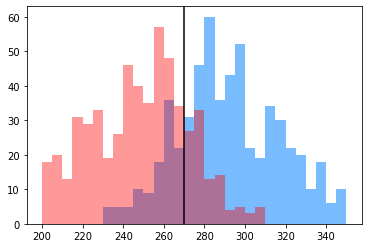

In [189]:
bins = np.arange(200, 351, 5)
plt.hist(dem_distr, bins=bins, color="dodgerblue", alpha=0.6);
plt.hist(rep_distr, bins=bins, color="red", alpha=0.4);
plt.axvline(x=270, color="black");

In [190]:
# biden win probabilities in battleground states
for state in battlegrounds:

    res = df_all[state].value_counts(normalize=True)["D"]
    print(state, res)

Arizona 0.70525
Colorado 0.98733
Florida 0.67452
Georgia 0.50132
Iowa 0.46803
Maine 0.98614
Michigan 0.87402
Minnesota 0.92297
Nevada 0.75093
New Hampshire 0.97499
New Mexico 0.89175
North Carolina 0.64769
Ohio 0.36977
Pennsylvania 0.83634
Texas 0.34988
Virginia 0.98709
Wisconsin 0.88437


In [126]:
(dem_distr > 270).sum() / n_mc

0.9911

Assuming states are independent gives a massive Biden win probability.

In [19]:
def simulate_state(state, n_mc=10000, bandwidth=5, shy_trump=0, shy_biden=0):
    mapping = {True: "D", False: "R"}
    
    df = wide[state].dropna()[["Trump", "Biden"]]
    df = df[df.index >= "2020-07"]
        
    net_biden = (df.Biden + shy_biden - df.Trump - shy_trump).to_frame()
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(net_biden)
        
    samples = kde.sample(n_mc)
    results = np.squeeze(samples) > 0    
    results = np.array(list(map(mapping.get, results)))
    
    return results
    

## Add shy trump factor

In [127]:
dict_shy_trump = {'Arizona': 5.979,
 'Colorado': 4.242,
 'Florida': 2.365,
 'Georgia': 3.966,
 'Iowa': 8.694,
 'Maine': 5.711,
 'Michigan': 7.024,
 'Minnesota': 7.782,
 'Nevada': 3.793,
 'New Hampshire': 6.726,
 'New Mexico': 4.695,
 'North Carolina': 5.333,
 'Ohio': 8.049,
 'Pennsylvania': 6.762,
 'Texas': 4.261,
 'Virginia': 4.391,
 'Wisconsin': 7.11}

In [128]:
dict_shy_biden = {'Arizona': 4.843,
 'Colorado': 3.011,
 'Florida': 2.91,
 'Georgia': 4.883,
 'Iowa': 5.674,
 'Maine': 0.363,
 'Michigan': 3.213,
 'Minnesota': 2.769,
 'Nevada': 4.075,
 'New Hampshire': 1.956,
 'New Mexico': 3.303,
 'North Carolina': 2.516,
 'Ohio': 4.382,
 'Pennsylvania': 0.442,
 'Texas': 8.708,
 'Virginia': 0.059,
 'Wisconsin': 1.752}

In [144]:
for state in battlegrounds:
    results = simulate_state(state, n_mc=n_mc, bandwidth=5, 
                             shy_trump=dict_shy_trump[state], shy_biden=0)
    df_all[state] = results

In [145]:
dem_distr = np.empty(n_mc)
rep_distr = np.empty(n_mc)

for row in df_all.itertuples(name=None):
    i = row[0]
    vals = np.array(row[1:])
    idx_d = np.where(vals == "D")[0]
    idx_r = np.where(vals == "R")[0]
    voted_dem = df_all.columns[idx_d]
    voted_rep = df_all.columns[idx_r]
    dem_total = votes_per_state[voted_dem].sum()
    rep_total = votes_per_state[voted_rep].sum()
  
    dem_distr[i] = dem_total
    rep_distr[i] = rep_total


In [146]:
(dem_distr > 270).sum() / n_mc

0.5699

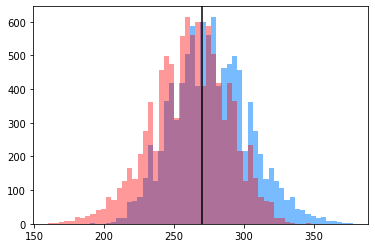

In [147]:
plt.hist(dem_distr, bins=50, color="dodgerblue", alpha=0.6);
plt.hist(rep_distr, bins=50, color="red", alpha=0.4);
plt.axvline(x=270, color="black");